In [1]:
!pip install -U tensorflow-gpu

Requirement already up-to-date: tensorflow-gpu in /usr/local/lib/python3.6/dist-packages (2.0.0)


In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D,Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [1]:
# Global Flags to control Data & Training/Valdiation
download = False
validation = False

In [0]:
# downloads and extracts, For Local/G-Drive
base_url = '/content/drive/My Drive/personal_hackathons/DataSet/'


if download :
    _URL = 'http://hck.re/kkBIfM'
    path_to_zip = tf.keras.utils.get_file(base_url +'lunar_rock.zip' , origin=_URL, extract=True)
    PATH = os.path.join(os.path.dirname(path_to_zip), 'lunar_rock')
    print("Paths to the ZIP File : {}".format(path_to_zip))

else :
    PATH='/content/drive/My Drive/personal_hackathons/DataSet/lunar_rock/'

In [6]:
print("Paths to the Data File : {}".format(PATH))

Paths to the Data File : /content/drive/My Drive/personal_hackathons/DataSet/lunar_rock/


In [0]:
# Unzip Downloaded data if Downloading is required

if download :

    os.chdir(PATH)  #change dir
    !mkdir train  #create a directory named train/
    !mkdir test  #create a directory named test/
    !unzip train.zip -d PATH  #unzip data in train/
    !unzip  test.zip  -d PATH #unzip data in test/
    !unzip sample_submission.csv.zip
    !unzip train_labels.csv.zip

In [7]:
train_dir = os.path.join(PATH, 'train')
train_lg_dir = os.path.join(train_dir, 'Large')  # directory with our training Large Lunar rock pictures
train_sm_dir = os.path.join(train_dir, 'Small')  # directory with our training Small Lunar rock pictures

print("Paths  Train : {} ".format(train_dir))
print("Paths  Train Large : {} ".format(train_lg_dir))
print("Paths  Train Small: {} ".format(train_sm_dir))

if validation : 
    validation_dir = os.path.join(PATH, 'validation')
    validation_lg_dir = os.path.join(validation_dir, 'Large')  # directory with our Large Lunar rock pictures
    validation_sm_dir = os.path.join(validation_dir, 'Small')  # directory with our Small Lunar rock pictures

Paths  Train : /content/drive/My Drive/personal_hackathons/DataSet/lunar_rock/train 
Paths  Train Large : /content/drive/My Drive/personal_hackathons/DataSet/lunar_rock/train/Large 
Paths  Trai Small: /content/drive/My Drive/personal_hackathons/DataSet/lunar_rock/train/Small 


In [0]:
num_lg_tr = len(os.listdir(train_lg_dir))
num_sm_tr = len(os.listdir(train_sm_dir))
total_train = num_lg_tr + num_sm_tr

if validation :
    
    num_lg_val = len(os.listdir(validation_lg_dir))
    num_sm_val = len(os.listdir(validation_sm_dir))
    total_val = num_cats_val + num_dogs_val

In [9]:
print('total training Large images:', num_lg_tr)
print('total training Small images:', num_sm_tr)
print("Total training images:", total_train)

print("--")

if validation :
    print('total validation Large images:', num_lg_val)
    print('total validation Small images:', num_sm_val)
    print("Total validation images:", total_val)

total training Large images: 5999
total training Small images: 5999
Total training images: 11998
--


In [0]:
batch_size = 64
EPOCHS = 15
IMG_HEIGHT = 224 # As using VGG Net
IMG_WIDTH = 224 # As using VGG Net

In [0]:
# Evaluate baseline Model
def evaluation(model,generator,data = "Training"):
  print("--------------Evaluating {} Dataset--------------".format(data))
  results = model.evaluate_generator(generator=generator,verbose=1)
  precision=0
  recall=0
  for name, value in zip(model.metrics_names, results):
    print(name, ': ', value)

    if name.strip() == 'precision':
      precision = value

    if name.strip() == 'recall':
      recall = value

  if precision !=0 and recall!=0 :
    f1 = (2 * precision * recall)/(precision+recall)
    print("f1 : ",f1)


def plot_metrices(EPOCHS,history,if_val=True):
  
  epochs = range(EPOCHS)

  plt.title('Accuracy')
  plt.plot(epochs,  history.history['accuracy'], color='blue', label='Train')
  if if_val:
    plt.plot(epochs, history.history['val_accuracy'], color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  _ = plt.figure()
  plt.title('Loss')
  plt.plot(epochs, history.history['loss'], color='blue', label='Train')
  if if_val:
    plt.plot(epochs, history.history['val_loss'], color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  _ = plt.figure()
  plt.title('False Negatives')
  plt.plot(epochs, history.history['fn'], color='blue', label='Train')
  if if_val:
    plt.plot(epochs, history.history['val_fn'], color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('False Negatives')
  plt.legend()

def plot_confusion_matrix(predict,generator,threshold):
  # Confusion Matrix

  
  labels = generator.classes
  labels_pred = (predict[:,0] > threshold).astype(np.int)

  cm = confusion_matrix(labels,labels_pred)

  plt.matshow(cm, alpha=0)
  plt.title('Confusion matrix')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  for (i, j), z in np.ndenumerate(cm):
      plt.text(j, i, str(z), ha='center', va='center')

  plt.show()

  print('Legitimate Customers Detected (True Negatives): ', cm[0][0])
  print('Legitimate Customers Incorrectly Detected (False Positives): ', cm[0][1])
  print('Loan Deafulters  Missed (False Negatives): ', cm[1][0])
  print('Loan Deafulters Detected (True Positives): ', cm[1][1])
  print('Total Loan Deafulters Customers: ', np.sum(cm[1]))

def submission_categorical(model,submission_csv = '/content/drive/My Drive/personal_hackathons/DataSet/lunar_rock/results_01.pickle'):

  # Instantiate Generator
  test_datagen = ImageDataGenerator(rescale=1./255)
  test_dir = '/content/drive/My Drive/personal_hackathons/DataSet/lunar_rock/PATH/'

  test_generator = test_datagen.flow_from_directory(
          test_dir,
          target_size=(IMG_HEIGHT, IMG_WIDTH),
          # color_mode="rgb",
          shuffle = False,
          class_mode='binary',
          batch_size=batch_size)
  
  # Check test Files
  filenames = test_generator.filenames
  nb_samples = len(filenames)
  print("Test Size : {}".format(nb_samples))
  # print(filenames)

  # Model Prediction
  test_generator.reset()
  predict = model.predict_generator(test_generator,verbose=1)
  print("Model Prediction Shape {}".format(predict.shape))

  labels = train_data_gen.class_indices
  predicted_class_indices=np.argmax(predict,axis=1)

    
  print("Labels : {}".format(labels) )
  print("Class Indices {}".format(predicted_class_indices))

  labels = dict((v,k) for k,v in labels.items())
  predictions = [labels[k] for k in predicted_class_indices]


  results=pd.DataFrame({"Image_File":filenames,
                        "Class":predictions})
  print("Distribution : {} ".format(results['Class'].value_counts()))

  # Write Sumission
  with open(submission_name,'wb') as f :
    pickle.dump(results,f)

  return results

def submission_binary(model,threshold =  0.4,
                      submission_name='lunar01_m1.pickle'):
  
  # Instantiate Generator
  test_datagen = ImageDataGenerator(rescale=1./255)
  test_dir = '/content/drive/My Drive/personal_hackathons/DataSet/lunar_rock/PATH/'

  test_generator = test_datagen.flow_from_directory(
          test_dir,
          target_size=(IMG_HEIGHT, IMG_WIDTH),
          # color_mode="rgb",
          shuffle = False,
          class_mode='binary',
          batch_size=batch_size)
  
  # Check test Files
  filenames = test_generator.filenames
  nb_samples = len(filenames)
  print("Test Size : {}".format(nb_samples))
  # print(filenames)

  # Model Prediction
  test_generator.reset()
  predict = model.predict_generator(test_generator,verbose=1)
  print("Model Prediction Shape {}".format(predict.shape))

  labels = train_data_gen.class_indices
  print("Labels : {}".format(labels) )

  # Predicting Classes based on Threshold
  predict_class = predict > threshold
  predict_class = predict_class.reshape(1,-1)
  predict_class = predict_class[0]

  results=pd.DataFrame({"Image_File":filenames,
                      "Class":predict_class})
  
  results['Image_File'] = results['Image_File'].apply(lambda x : x[12:])
  results['Class'] = results['Class'].map({True: 'Small', False: "Large"})
  
  print("Distribution : {} ".format(results['Class'].value_counts()))

  # Write Sumission
  with open(submission_name,'wb') as f :
    pickle.dump(results,f)

  return results

In [12]:
# When using whole dataset for training

train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary',
                                                           )

## While Splitting into Train & Validation

# train_image_generator = ImageDataGenerator(validation_split=0.2,rescale=1./255) # Generator for our training data

# train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
#                                                            directory=train_dir,
#                                                            shuffle=True,
#                                                            target_size=(IMG_HEIGHT, IMG_WIDTH),
#                                                            class_mode='binary',
#                                                            subset='training')

# val_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
#                                                               directory=train_dir,
#                                                               shuffle=False,
#                                                               target_size=(IMG_HEIGHT, IMG_WIDTH),
#                                                               class_mode='binary',
#                                                               subset='validation')

Found 11998 images belonging to 2 classes.


In [0]:
# Only to be used When we have a different Validation Set 

if validation :
    validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data
    val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                                  directory=validation_dir,
                                                                  target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                                  class_mode='binary')

In [0]:
sample_training_images, sample_training_labels = next(train_data_gen)
sample_training_labels[:5]

array([0., 0., 0., 1., 1.], dtype=float32)

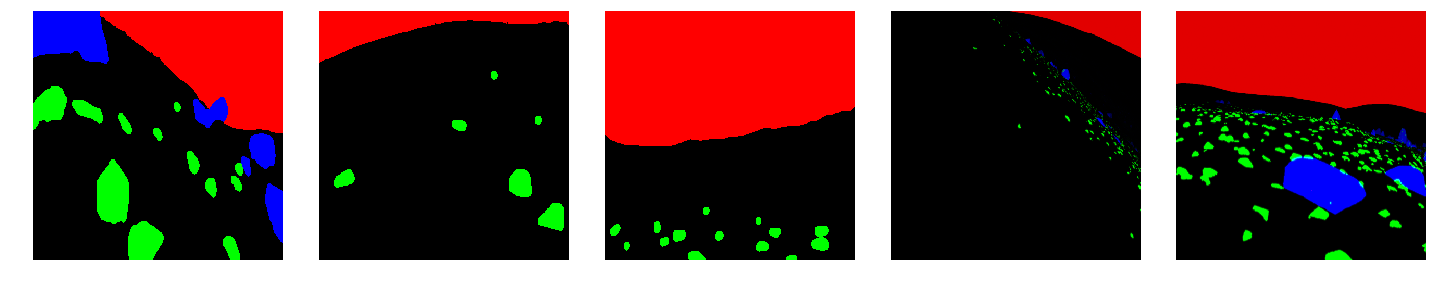

In [0]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(sample_training_images[:5])

In [0]:
def model_metrics():
  metrics = [
    keras.metrics.Accuracy(name='accuracy'),
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc')
  ]

  return metrics

metrics = model_metrics()

In [0]:
def make_model1(metrics=metrics):

  vgg16_model = keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224,224,3)))

  # Train Last 4 Layers
  for layer in vgg16_model.layers:
    layer.trainable = False

  model = Sequential([
      vgg16_model,
      Flatten(),
      Dense(1024, activation='relu'),
      Dropout(0.2),
      Dense(512, activation='relu'),
      Dense(1, activation='sigmoid')
  ])

  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=metrics)

  model.summary()

  return model

In [0]:
def make_model2(metrics=metrics):
  model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])
  model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=metrics)

  model.summary()

  return model


In [16]:
model = make_model1()
history = model.fit_generator(
    train_data_gen,
    epochs=EPOCHS,
    # validation_data=val_data_gen,
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 40,931,137
Trainable params: 26,216,449
Non-trainable params: 14,714,688
___________________________________

In [0]:
 # Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model shuold be saved to HDF5.
model.save(PATH+'my_model01_m2.h5') 

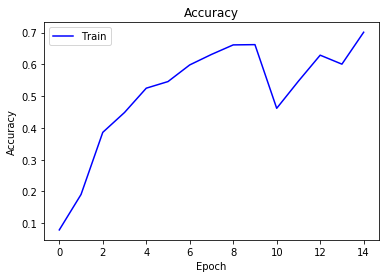

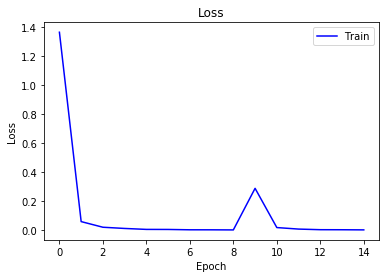

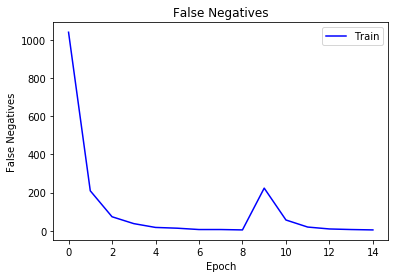

In [0]:
plot_metrices(EPOCHS,history,if_val=False)

In [0]:
evaluation(model,train_data_gen,data = "Training")
# evaluation(model,val_data_gen,data = "Validation")

--------------Evaluating Training Dataset--------------
94/94 [==============================] - 191s 2s/step - loss: 0.0013 - accuracy: 0.6333 - tp: 5995.0000 - fp: 0.0000e+00 - tn: 5999.0000 - fn: 4.0000 - precision: 1.0000 - recall: 0.9993 - auc: 1.0000
loss :  0.00125052198111123
accuracy :  0.63327223
tp :  5995.0
fp :  0.0
tn :  5999.0
fn :  4.0
precision :  1.0
recall :  0.9993332
auc :  0.9999997
f1 :  0.9996665200300842


In [0]:
generator = train_data_gen
predict = model.predict_generator(train_data_gen,verbose=1)

94/94 [==============================] - 181s 2s/step


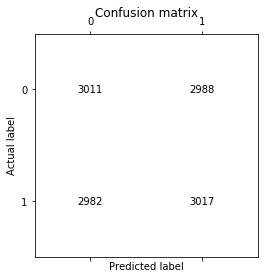

Legitimate Customers Detected (True Negatives):  3011
Legitimate Customers Incorrectly Detected (False Positives):  2988
Loan Deafulters  Missed (False Negatives):  2982
Loan Deafulters Detected (True Positives):  3017
Total Loan Deafulters Customers:  5999


In [0]:
plot_confusion_matrix(predict=predict,generator=train_data_gen,threshold=0.2)

In [0]:
sub = submission_binary(model,threshold=0.4,submission_name=PATH+'lunar01_m2.pickle')

Found 7534 images belonging to 1 classes.
Test Size : 7534
59/59 [==============================] - 108s 2s/step
Model Prediction Shape (7534, 1)
Labels : {'Large': 0, 'Small': 1}
Distribution : Large    3782
Small    3752
Name: Class, dtype: int64 


,Image_File,Class
0,lg 988 (1).png,Small
1,lg 988 (10).png,Small
2,lg 988 (100).png,Small
3,lg 988 (101).png,Small
4,lg 988 (102).png,Small
5,lg 988 (103).png,Small
6,lg 988 (104).png,Small
7,lg 988 (105).png,Small
8,lg 988 (106).png,Small
9,lg 988 (107).png,Small


## Evalaution Prediction to determine Threshold. 

submission_binary function is written in different cells below

In [0]:
# Instantiate Generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_dir = '/content/drive/My Drive/personal_hackathons/DataSet/lunar_rock/PATH/'

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        # color_mode="rgb",
        shuffle = False,
        class_mode='binary',
        batch_size=batch_size)

# Check test Files
filenames = test_generator.filenames
nb_samples = len(filenames)
print("Test Size : {}".format(nb_samples))
# print(filenames)

# Model Prediction
test_generator.reset()
predict = model.predict_generator(test_generator,verbose=1)
print("Model Prediction Shape {}".format(predict.shape))

labels = train_data_gen.class_indices
print("Labels : {}".format(labels) )

  

Found 7534 images belonging to 1 classes.
Test Size : 7534
59/59 [==============================] - 108s 2s/step
Model Prediction Shape (7534, 1)
Labels : {'Large': 0, 'Small': 1}


In [0]:
threshold = 0.3
submission_name=PATH+'lunar01_m2.pickle'

In [0]:
# Predicting Classes based on Threshold
predict_class = predict > threshold
predict_class = predict_class.reshape(1,-1)
predict_class = predict_class[0]

results=pd.DataFrame({"Image_File":filenames,
                    "Class":predict_class})

results['Image_File'] = results['Image_File'].apply(lambda x : x[12:])
results['Class'] = results['Class'].map({True: 'Small', False: "Large"})

print("Distribution : {} ".format(results['Class'].value_counts()))

# Write Sumission
with open(submission_name,'wb') as f :
  pickle.dump(results,f)

Distribution : Large    3778
Small    3756
Name: Class, dtype: int64 
